# 라이브러리 불러오기

In [465]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import catboost
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from lightgbm import LGBMClassifier
from tqdm import tqdm
import time

In [466]:
train = pd.read_csv(r'..\Data\train.csv')
test = pd.read_csv(r'..\Data\test.csv')
submission = pd.read_csv(r'..\Data\sample_submission.csv')

# Feature 설명

index

gender: 성별   (o)

car: 차량 소유 여부   (o)

reality: 부동산 소유 여부   (o)

child_num: 자녀 수   

income_total: 연간 소득  (o)

income_type: 소득 분류   
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   

edu_type: 교육 수준   
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   

family_type: 결혼 여부   
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   

house_type: 생활 방식   
    ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   

DAYS_BIRTH: 출생일   (o)
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   

DAYS_EMPLOYED: 업무 시작일   (o)   
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   

FLAG_MOBIL: 핸드폰 소유 여부  (o) 

work_phone: 업무용 전화 소유 여부   (o)

phone: 전화 소유 여부  (o) 

email: 이메일 소유 여부   (o)

occyp_type: 직업 유형	   												

family_size: 가족 규모  (o) 

begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미 (o)     

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   

## 중복된 요소 삭제

In [467]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'])]

In [468]:
train['identity']

0        F202500.0Commercial associate-13899-4709
1        F247500.0Commercial associate-11380-1540
2                     M450000.0Working-19087-4434
3        F202500.0Commercial associate-15088-2092
4               F157500.0State servant-15037-2105
                           ...                   
26452           F225000.0State servant-12079-1984
26453                 F180000.0Working-15291-2475
26454                 F292500.0Working-10082-2015
26455                  M171000.0Working-10145-107
26456                  F81000.0Working-19569-1013
Name: identity, Length: 26457, dtype: object

In [469]:
subset = train['identity'].value_counts()>1

In [472]:
subset = subset*1

In [358]:
# print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
# print(f"test set 중복데이터가 아닌 사람의 수 : {sum(test['identity'].value_counts()==1)}명")
# print('-'*60)
# print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")
# print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(test['identity'].value_counts()>=2)}명")

In [359]:
# identity_counts = train['identity'].value_counts()
# print(identity_counts)
# dup_case_1 = identity_counts.index[0]

In [360]:
print(train.shape)
print(test.shape)
train.info()

(26457, 20)
(10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-n

# 데이터 전처리
## 1. 결측치 제거

In [361]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [362]:
train_and_test = [train, test]

In [363]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

## - 중복된 데이터 처리

In [364]:
# train['card_no'] = 0 #=> 중복된 데이터를 drop 하는 대신 제일 첫번째 데이터에 card_no라는 변수를 추가

In [365]:
# train_overlap = pd.DataFrame(columns=train.columns)

In [366]:
# for i in range (len(train)):
#     overlap = train[(train['DAYS_BIRTH'] == train['DAYS_BIRTH'][i])&(train['income_total'] == train['income_total'][i])]
#     overlap['card_no'][i] = (len(overlap))
#     list_drop = overlap.index[1:].values.tolist()
#     overlap = overlap.iloc[0:1]
#     train = train.drop(list_drop, axis = 0)
#     train_overlap = pd.concat([train_overlap, overlap])

In [367]:
# train_overlap.to_csv(r'..\Data\train_filtered.csv', index=False)

## - Child_num: 자녀의 유무로 구분 (nominal)

<AxesSubplot:>

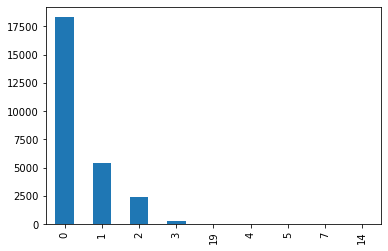

In [368]:
train['child_num'].value_counts(sort=False).plot.bar()

In [369]:
for dataset in train_and_test:
    dataset.loc[dataset['child_num'] != 0, 'child_num'] = 'kids_no'
    dataset.loc[dataset['child_num'] == 0, 'child_num'] = 'kids_yes'

# a for no kids/ b for whom has kids

## - income_total (ordinal)

(array([1.6212e+04, 8.3300e+03, 1.5300e+03, 2.0600e+02, 1.2100e+02,
        4.4000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00]),
 array([  27000.,  181800.,  336600.,  491400.,  646200.,  801000.,
         955800., 1110600., 1265400., 1420200., 1575000.]),
 <BarContainer object of 10 artists>)

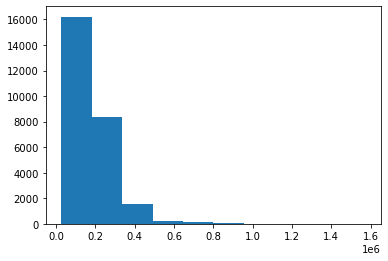

In [370]:
plt.hist(train['income_total'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1a4e1bfdd30>,
 'caps': [<matplotlib.lines.Line2D at 0x1a4e1c1b080>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a4e1c0b860>],
 'medians': [<matplotlib.lines.Line2D at 0x1a4e1c1b630>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a4e1c1b908>],
 'means': []}

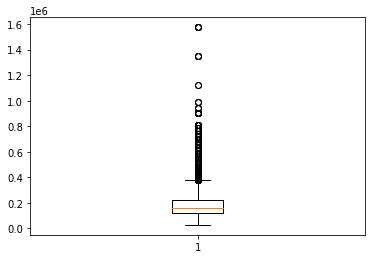

In [371]:
plt.boxplot(train['income_total']) # 이상치가 존재하나 범주형 데이터로 변형할 것이기에 그대로 사용한다.

In [372]:
## for lgbm: min-max scaling
# train_and_test = [train, test]
# for dataset in train_and_test:
#     scaler = MinMaxScaler()
#     income_fitted = scaler.fit_transform(dataset[['income_total']])
#     dataset['income_total'] = income_fitted

In [373]:
# # for lgbm: std scailing
# train_and_test = [train, test]
# for dataset in train_and_test:
#     scaler = StandardScaler()
#     income_fitted = scaler.fit_transform(dataset[['income_total']])
#     dataset['income_total'] = income_fitted

In [374]:
# for Catboost
for dataset in train_and_test:
    Q1 = dataset['income_total'].quantile(0.2)
    Q2 = dataset['income_total'].quantile(0.4)
    Q3 = dataset['income_total'].quantile(0.6)
    Q4 = dataset['income_total'].quantile(0.8)
    Q5 = dataset['income_total'].quantile(1.0)
    bins_income = [0, Q1, Q2, Q3, Q4, Q5]
    labels_income = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['income_total'], bins = bins_income, labels = labels_income, include_lowest= True)
    dataset['income_total'] = cuts

In [375]:
train['income_total']

0        d
1        d
2        e
3        d
4        c
        ..
26452    d
26453    c
26454    e
26455    c
26456    a
Name: income_total, Length: 26457, dtype: category
Categories (5, object): ['a' < 'b' < 'c' < 'd' < 'e']

## - Discrete variables

## - fanily_size (ordinal)

In [376]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

(array([1878., 5357.,    0., 1789.,    0.,  846.,  106.,    0.,   14.,
          10.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

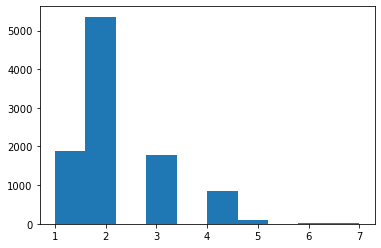

In [377]:
plt.hist(test['family_size'])

In [378]:
test.describe()

,index,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
count,10000.00000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,31456.50000,-16020.466400,59776.690400,1.0,0.227600,0.296300,0.085600,2.202700,-26.272400
std,2886.89568,4197.672887,138121.224504,0.0,0.419304,0.456648,0.279786,0.898272,16.348557
min,26457.00000,-25152.000000,-15661.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,28956.75000,-19483.250000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,31456.50000,-15606.000000,-1577.000000,1.0,0.000000,0.000000,0.000000,2.000000,-25.000000
75%,33956.25000,-12539.000000,-410.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,36456.00000,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,7.000000,0.000000


In [379]:
train_and_test = [train, test]  

In [380]:
for dataset in train_and_test:
    bins_family = [0, 1, 2, 21]
    labels_family = ['a', 'b', 'c']
    cuts = pd.cut(dataset['family_size'], bins = bins_family, labels = labels_family)
    dataset['family_size'] = cuts

# a for single, b for double, c for more than double

In [381]:
train['family_size'].isnull().sum()

0

## - income_type (nominal)

In [382]:
for dataset in train_and_test:
    dataset.loc[dataset['income_type']=='Student', 'income_type'] = 'Working' # ==> student 데이터의 수가 적고 working 데이터가 크고 다양하다는 점에서 편입함.

## - edu_type (ordinal)

In [383]:
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

In [384]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,kids_yes,a,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,b,-60.0
1,26458,F,N,Y,kids_yes,b,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,b,-36.0
2,26459,F,N,Y,kids_yes,a,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,b,-40.0
3,26460,M,Y,N,kids_yes,a,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,b,-41.0
4,26461,F,Y,Y,kids_yes,d,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,b,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,kids_yes,d,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,b,-19.0
9996,36453,M,Y,Y,kids_yes,d,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,b,-34.0
9997,36454,F,N,Y,kids_yes,e,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,b,-55.0
9998,36455,F,Y,N,kids_yes,c,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,b,-33.0


In [385]:
test.groupby(['edu_type', 'income_total'])['income_total'].value_counts() # 확인해본 결과 석박사 과정과 대졸의 소득 분포가 큰 차이를 보이지 않기에 데이터를 합침.

edu_type                       income_total  income_total
Academic degree                b             b                  2
                               e             e                  7
Higher education               a             a                358
                               b             b                355
                               c             c                599
                               d             d                547
                               e             e                843
Incomplete higher              a             a                 46
                               b             b                 79
                               c             c                 94
                               d             d                 67
                               e             e                104
Lower secondary                a             a                 49
                               b             b                 21
                  

In [386]:
for dataset in train_and_test:
    dataset.loc[dataset['edu_type']=='Academic degree', 'edu_type'] = 'Higher education'
    dataset.loc[dataset['edu_type']=='Lower secondary', 'edu_type'] = 'Secondary / secondary special'

In [387]:
train['edu_type'].value_counts()

Secondary / secondary special    18252
Higher education                  7185
Incomplete higher                 1020
Name: edu_type, dtype: int64

In [388]:
for dataset in train_and_test:
  dataset.loc[dataset['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 'a'
  dataset.loc[dataset['edu_type'] == 'Incomplete higher', 'edu_type'] = 'b'
  dataset.loc[dataset['edu_type'] == 'Higher education', 'edu_type'] = 'c'

## - family_type (nominal)

In [389]:
train['family_type'].value_counts()

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64

## - house_type (nominal)

In [390]:
train['house_type'].value_counts()
train['house_type'].unique()

array(['Municipal apartment', 'House / apartment', 'With parents',
       'Co-op apartment', 'Rented apartment', 'Office apartment'],
      dtype=object)

In [391]:
test.groupby(['house_type', 'income_total'])['income_total'].value_counts() # 확인해본 결과 아파트 종류들의 소득 분포가 큰 차이를 보이지 않기에 데이터를 합침.

house_type           income_total  income_total
Co-op apartment      a             a                 16
                     b             b                  6
                     c             c                 13
                     d             d                 14
                     e             e                  9
House / apartment    a             a               2164
                     b             b               1444
                     c             c               1928
                     d             d               1545
                     e             e               1814
Municipal apartment  a             a                 83
                     b             b                 37
                     c             c                 91
                     d             d                 57
                     e             e                 42
Office apartment     a             a                 11
                     b             b                  7


In [392]:
for dataset in train_and_test:
    houses = ['Municipal apartment', 'Co-op apartment', 'Rented apartment', 'Office apartment']
    for type in houses:
        dataset.loc[dataset['house_type']==type, 'house_type'] = 'etc_apartment'

In [393]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,kids_yes,d,Commercial associate,c,Married,etc_apartment,-13899,-4709,1,0,0,0,NaN,b,-6.0,1.0
1,1,F,N,Y,kids_no,d,Commercial associate,a,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,c,-5.0,1.0
2,2,M,Y,Y,kids_yes,e,Working,c,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,b,-22.0,2.0
3,3,F,N,Y,kids_yes,d,Commercial associate,a,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,b,-37.0,0.0
4,4,F,Y,Y,kids_yes,c,State servant,c,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,b,-26.0,2.0


## - DAYS_EMPLOYED (ordinal)
-  근무일수 데이터 중 양수의 값을 가지는 데이터를 0->Unemployed로 바꾼 후 각 분위에 해당하는 데이터를 'Short', 'Medium', 'Long', 'Very_Long'로 변환함.

 - [a < b < c < d < e] -> ['Unemployed', 'Short', 'Medium', 'Long', 'Very_Long']

In [394]:
# 'DAYS_EMPLOYED' preprocessing
for dataset in train_and_test:
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].abs()

    Q1 = dataset['DAYS_EMPLOYED'].quantile(0.25)
    Q2 = dataset['DAYS_EMPLOYED'].quantile(0.50)
    Q3 = dataset['DAYS_EMPLOYED'].quantile(0.75)

    bins = [0,1, Q1, Q2, Q3, 15713]
    labels = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['DAYS_EMPLOYED'], bins, right=True, labels=labels, include_lowest= True)
    dataset['DAYS_EMPLOYED'] = cuts


### Min-max scailing

In [395]:
# for dataset in train_and_test:
#     dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
#     dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].abs()
#     employed_fitted = scaler.fit_transform(dataset[['DAYS_EMPLOYED']])
#     dataset['DAYS_EMPLOYED'] = employed_fitted

In [396]:
train['DAYS_EMPLOYED'].value_counts()

c    6639
d    6608
e    6591
a    4438
b    2181
Name: DAYS_EMPLOYED, dtype: int64

In [397]:
test['DAYS_EMPLOYED'].isnull().sum()

0

## - DAYS_BIRTH: (ordinal)
살아온 일수를 절대값을 취한 후 연단위로 바꾸어 반올림함.

 - ['20s', '30s', '40s', '50s', '60s'] => ['a', 'b', 'c', 'd', 'e']

In [398]:
for dataset in train_and_test:
    dataset['DAYS_BIRTH'] = (dataset['DAYS_BIRTH']/365).abs().astype(object)
    bins = [20, 30, 40, 50, 60, 70]
    labels = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['DAYS_BIRTH'], bins = bins, right=True, labels=labels, include_lowest= True)
    dataset['DAYS_BIRTH'] = cuts
    # pd.get_dummies(dataset['DAYS_BIRTH'])

In [399]:
# for dataset in train_and_test:
#     dataset['DAYS_BIRTH'].abs()
#     birth_fitted = scaler.fit_transform(dataset[['DAYS_BIRTH']])
#     dataset['DAYS_BIRTH'] = birth_fitted

In [400]:
dataset['DAYS_BIRTH'].value_counts()

b    2851
c    2543
d    2213
a    1320
e    1073
Name: DAYS_BIRTH, dtype: int64

In [401]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          26457 non-null  int64   
 1   gender         26457 non-null  object  
 2   car            26457 non-null  object  
 3   reality        26457 non-null  object  
 4   child_num      26457 non-null  object  
 5   income_total   26457 non-null  category
 6   income_type    26457 non-null  object  
 7   edu_type       26457 non-null  object  
 8   family_type    26457 non-null  object  
 9   house_type     26457 non-null  object  
 10  DAYS_BIRTH     26457 non-null  category
 11  DAYS_EMPLOYED  26457 non-null  category
 12  FLAG_MOBIL     26457 non-null  int64   
 13  work_phone     26457 non-null  int64   
 14  phone          26457 non-null  int64   
 15  email          26457 non-null  int64   
 16  occyp_type     18286 non-null  object  
 17  family_size    26457 non-null  

## occupation (nominal)

In [402]:
train.occyp_type.value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [403]:
train['occyp_type'] = train['occyp_type'].fillna('no')
test['occyp_type'] = test['occyp_type'].fillna('no')

In [404]:
for dataset in train_and_test:
    dataset.loc[(dataset['occyp_type'] == 'no')&(dataset['DAYS_EMPLOYED'] != 'Unemployed'), 'occyp_type'] = 'no_response'
    dataset.loc[(dataset['occyp_type'] == 'no')&(dataset['DAYS_EMPLOYED'] == 'Unemployed'), 'occyp_type'] = 'no_job'

In [405]:
for dataset in train_and_test:
  dataset['occyp_type'] = dataset['occyp_type'].replace(['Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff'], 'etc')

In [406]:
test['occyp_type'].value_counts()

no_response              3152
Laborers                 1699
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
High skill tech staff     343
Medicine staff            343
Accountants               339
etc                       311
Cooking staff             198
Security staff            168
Cleaning staff            148
Name: occyp_type, dtype: int64

In [407]:
train['occyp_type'].value_counts()

no_response              8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
etc                       757
Cooking staff             457
Security staff            424
Cleaning staff            403
Name: occyp_type, dtype: int64

## begin_month (ordinal)
### 음수 값을 가진 데이터를 절대값을 취해주었으며, 0의 값을 가진 데이터의 경우 카드를 소지하지 않은 경우로 판단함.

In [408]:
# train['begin_month'].describe()

In [409]:
# train['begin_month'].head()
# train['begin_month'].describe() # 0의 값이 존재함 -> 어떤 의미? -> 카드를 발급받지 아니한 사람 (사유: 다양함 --> 신용불량, 소득 X, 신용등급이 낮은 사회 초년생 등)
# train['begin_month'].isnull().sum() # 결측치 없음
# len(train.loc[train['begin_month'] == 0, :]) # 카드를 소지하지 않은 사람의 수가 231명으로 보임.

In [410]:
# train['begin_month'] = train['begin_month'].abs()/12 # 음수 값을 가지던 데이터에 절대값처리.

In [411]:
# train['begin_month'].value_counts

- ['NoCard', '0_year', '1_year', '2_year', '3_year', '4+_years'] => ['a', 'b', 'c', 'd', 'e', 'f']

In [412]:
# for catboost
for dataset in train_and_test:
    dataset['begin_month'] = dataset['begin_month'].abs()/12
    bins = [0, 0.001, 1, 2, 3, 4, 5]
    labels = ['a', 'b', 'c', 'd', 'e', 'f']
    cuts = pd.cut(dataset['begin_month'], bins = bins, right=True, labels=labels, include_lowest= True)
    dataset['begin_month'] = cuts

In [413]:
## for lgbm
# for dataset in train_and_test:
#     dataset['begin_month'] = dataset['begin_month'].abs()
#     month_fitted = scaler.fit_transform(dataset[['begin_month']])
#     dataset['begin_month'] = month_fitted

In [414]:
train['begin_month']

0        b
1        b
2        c
3        e
4        d
        ..
26452    b
26453    e
26454    d
26455    f
26456    b
Name: begin_month, Length: 26457, dtype: category
Categories (6, object): ['a' < 'b' < 'c' < 'd' < 'e' < 'f']

In [415]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          26457 non-null  int64   
 1   gender         26457 non-null  object  
 2   car            26457 non-null  object  
 3   reality        26457 non-null  object  
 4   child_num      26457 non-null  object  
 5   income_total   26457 non-null  category
 6   income_type    26457 non-null  object  
 7   edu_type       26457 non-null  object  
 8   family_type    26457 non-null  object  
 9   house_type     26457 non-null  object  
 10  DAYS_BIRTH     26457 non-null  category
 11  DAYS_EMPLOYED  26457 non-null  category
 12  FLAG_MOBIL     26457 non-null  int64   
 13  work_phone     26457 non-null  int64   
 14  phone          26457 non-null  int64   
 15  email          26457 non-null  int64   
 16  occyp_type     26457 non-null  object  
 17  family_size    26457 non-null  

## 트레인 테스트 셋으로 전처리

In [416]:
train_x = train.drop(['credit', 'index'], axis = 1)
train_y = train[['credit']]
test_x = test.drop('index', axis = 1)

## encoding (one_hot_encoding for nominal, ordinal_encoding for ordinal)

In [417]:
# for catboost
feat_ordinal = ['begin_month','income_total', 'edu_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size']
feat_nominal = ['car', 'reality', 'child_num', 'income_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type' ]

In [418]:
# # for lgbm
# feat_ordinal = ['edu_type', 'DAYS_BIRTH', 'family_size']
# feat_nominal = ['car', 'reality', 'child_num', 'income_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type' ]

In [419]:
train_nom = pd.get_dummies(train_x[feat_nominal], drop_first=True) 
train_ord = train_x[feat_ordinal]
encoder = OrdinalEncoder()
encoder.fit(train_ord.values.tolist())
train_ord_encoded = encoder.transform(train_ord.values.tolist())
train_ord = pd.DataFrame(train_ord_encoded, columns= feat_ordinal)
train_x = pd.concat([train_nom, train_ord], axis = 1)

In [420]:
test_nom = pd.get_dummies(test_x[feat_nominal], drop_first=True) 
test_ord = test_x[feat_ordinal]
encoder = OrdinalEncoder()
encoder.fit(test_ord.values.tolist())
test_ord_encoded = encoder.transform(test_ord.values.tolist())
test_ord = pd.DataFrame(test_ord_encoded, columns= feat_ordinal)
test_x = pd.concat([test_nom, test_ord], axis = 1)

# [데이터 모델링]

In [421]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FLAG_MOBIL                        26457 non-null  int64  
 1   work_phone                        26457 non-null  int64  
 2   phone                             26457 non-null  int64  
 3   email                             26457 non-null  int64  
 4   car_Y                             26457 non-null  uint8  
 5   reality_Y                         26457 non-null  uint8  
 6   child_num_kids_yes                26457 non-null  uint8  
 7   income_type_Pensioner             26457 non-null  uint8  
 8   income_type_State servant         26457 non-null  uint8  
 9   income_type_Working               26457 non-null  uint8  
 10  family_type_Married               26457 non-null  uint8  
 11  family_type_Separated             26457 non-null  uint8  
 12  fami

In [422]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FLAG_MOBIL                        10000 non-null  int64  
 1   work_phone                        10000 non-null  int64  
 2   phone                             10000 non-null  int64  
 3   email                             10000 non-null  int64  
 4   car_Y                             10000 non-null  uint8  
 5   reality_Y                         10000 non-null  uint8  
 6   child_num_kids_yes                10000 non-null  uint8  
 7   income_type_Pensioner             10000 non-null  uint8  
 8   income_type_State servant         10000 non-null  uint8  
 9   income_type_Working               10000 non-null  uint8  
 10  family_type_Married               10000 non-null  uint8  
 11  family_type_Separated             10000 non-null  uint8  
 12  famil

In [423]:
# print(train_x.shape, test_x.shape, train_y.shape)

In [424]:
train.isnull().sum()

index            0
gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64

In [425]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score


X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(19842, 34)
(19842, 1)
Validation set: 
(6615, 34)
(6615, 1)


In [426]:
# rf_clf=RandomForestClassifier()
# rf_clf.fit(X_train, y_train)
# y_pred_rf=rf_clf.predict_proba(X_val)
# rf_clf.classes_

# # print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_rf)}")

In [427]:
# gbm_clf=GradientBoostingClassifier()
# gbm_clf.fit(X_train, y_train)
# y_pred_gbm=gbm_clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_gbm)}")

In [428]:
# ada_clf=AdaBoostClassifier()
# ada_clf.fit(X_train, y_train)
# y_pred_ada=ada_clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_ada)}")

In [429]:
# lgbm_clf = LGBMClassifier()
# lgbm_clf.fit(X_train, y_train)
# y_pred_lgbm = lgbm_clf.predict_proba(X_val)


# print("훈련 세트 정확도: {:.3f}".format(lgbm_clf.score(X_train, y_train)))
# print("테스트 세트 정확도: {:.3f}".format(lgbm_clf.score(X_val, y_val)))

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_lgbm)}")

In [430]:
cbt_clf = CatBoostClassifier()
cbt_clf.fit(X_train, y_train)
y_pred_cbt = cbt_clf.predict_proba(X_val)


print("훈련 세트 정확도: {:.3f}".format(cbt_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cbt_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_cbt)}")

Learning rate set to 0.092151
0:	learn: 1.0555595	total: 19.7ms	remaining: 19.7s
1:	learn: 1.0210746	total: 26.9ms	remaining: 13.4s
2:	learn: 0.9932685	total: 39.2ms	remaining: 13s
3:	learn: 0.9698924	total: 50.8ms	remaining: 12.6s
4:	learn: 0.9513433	total: 57.8ms	remaining: 11.5s
5:	learn: 0.9352720	total: 66.1ms	remaining: 11s
6:	learn: 0.9219334	total: 74.5ms	remaining: 10.6s
7:	learn: 0.9106317	total: 82.9ms	remaining: 10.3s
8:	learn: 0.9018432	total: 88.3ms	remaining: 9.72s
9:	learn: 0.8940724	total: 97ms	remaining: 9.6s
10:	learn: 0.8873364	total: 106ms	remaining: 9.49s
11:	learn: 0.8817920	total: 114ms	remaining: 9.42s
12:	learn: 0.8769961	total: 123ms	remaining: 9.35s
13:	learn: 0.8731759	total: 132ms	remaining: 9.29s
14:	learn: 0.8697945	total: 139ms	remaining: 9.14s
15:	learn: 0.8668846	total: 148ms	remaining: 9.08s
16:	learn: 0.8645006	total: 159ms	remaining: 9.2s
17:	learn: 0.8620265	total: 172ms	remaining: 9.4s
18:	learn: 0.8599280	total: 183ms	remaining: 9.45s
19:	learn:

<BarContainer object of 34 artists>

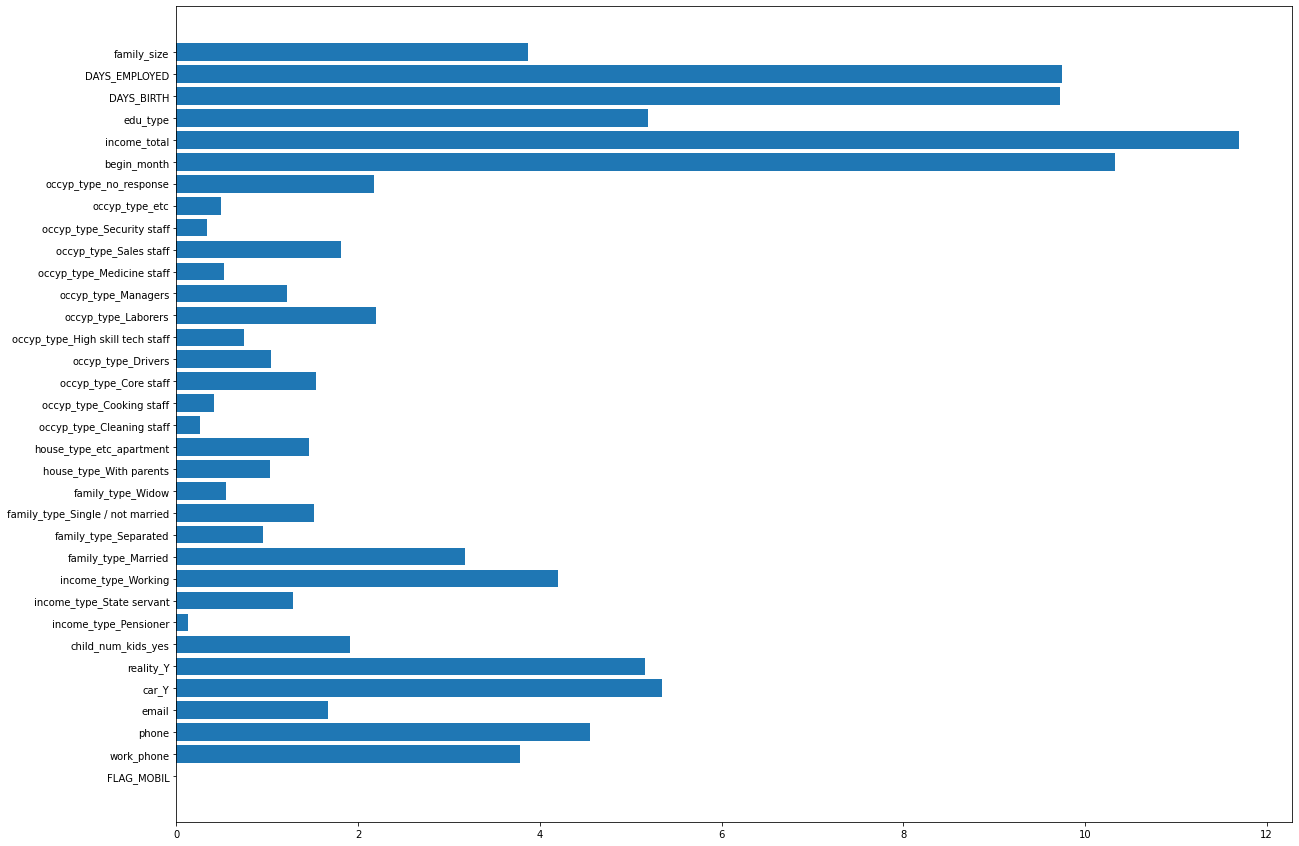

In [431]:
cbt_clf.get_feature_importance()

plt.figure(figsize=(20, 15))

plt.barh(X_train.columns, cbt_clf.get_feature_importance())

In [432]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cbt_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cbt_clf.fit(X_train, y_train)
        
        predictions=cbt_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cbt_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cbt_clf)

Learning rate set to 0.092455
0:	learn: 1.0551811	total: 15.9ms	remaining: 15.9s
1:	learn: 1.0204454	total: 26.6ms	remaining: 13.3s
2:	learn: 0.9924705	total: 50.2ms	remaining: 16.7s
3:	learn: 0.9688999	total: 59.5ms	remaining: 14.8s
4:	learn: 0.9502252	total: 68.8ms	remaining: 13.7s
5:	learn: 0.9341907	total: 78.4ms	remaining: 13s
6:	learn: 0.9213047	total: 88.1ms	remaining: 12.5s
7:	learn: 0.9105089	total: 97.5ms	remaining: 12.1s
8:	learn: 0.9013250	total: 107ms	remaining: 11.8s
9:	learn: 0.8933156	total: 117ms	remaining: 11.6s
10:	learn: 0.8864984	total: 128ms	remaining: 11.5s
11:	learn: 0.8811416	total: 142ms	remaining: 11.7s
12:	learn: 0.8764107	total: 152ms	remaining: 11.6s
13:	learn: 0.8723370	total: 161ms	remaining: 11.4s
14:	learn: 0.8688243	total: 173ms	remaining: 11.3s
15:	learn: 0.8660106	total: 183ms	remaining: 11.3s
16:	learn: 0.8633326	total: 193ms	remaining: 11.2s
17:	learn: 0.8611366	total: 203ms	remaining: 11.1s
18:	learn: 0.8594711	total: 213ms	remaining: 11s
19:	lea

In [433]:
my_submission

array([[0.07620161, 0.0777338 , 0.84606459],
       [0.18160171, 0.1362881 , 0.68211019],
       [0.0919039 , 0.12991402, 0.77818208],
       ...,
       [0.02882377, 0.13095139, 0.84022484],
       [0.09434046, 0.14388594, 0.76177361],
       [0.0488301 , 0.65499492, 0.29617498]])

In [434]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [435]:
my_submission.shape

(10000, 3)

In [436]:
submission.loc[:, 1:] = my_submission

In [437]:
submission

,index,0,1,2
0,26457,0.076202,0.077734,0.846065
1,26458,0.181602,0.136288,0.682110
2,26459,0.091904,0.129914,0.778182
3,26460,0.168005,0.075411,0.756584
4,26461,0.065175,0.301594,0.633231
...,...,...,...,...
9995,36452,0.131168,0.197640,0.671192
9996,36453,0.118279,0.321281,0.560440
9997,36454,0.028824,0.130951,0.840225
9998,36455,0.094340,0.143886,0.761774


In [438]:
# submission.to_csv(r'..\Data\submission_JH_lgbm2.csv', index=False)